In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import fisher_exact
from ucimlrepo import fetch_ucirepo
import missingno as msno

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score
)
from sklearn.inspection import permutation_importance

# shared style for full notebook
plt.style.use('ggplot')
colors = ['#069af3', '#047495']

# Mushroom Classification

## Project Topic

The goal of this project is to build an accurate model for predicting whether a mushroom is edible based on categorical information about its features.

This is a binary classification problem where a mushroom can be classified as either edible or poisonous. I will work up to a sophisticated model by exploring the performance of models utilizing logistic regression, decision trees with ensemble methods, and support vector machines.

My motivation behind this project is to explore the benefits and drawbacks of different classification approaches on a straightforward binary classification problem and to develop intuition about an optimal approach for similar problems in the future.

## Data

This project uses the "Mushroom" dataset from the UCI Machine Learning Repository:

**Mushroom [Dataset]. (1981). UCI Machine Learning Repository.** [https://doi.org/10.24432/C5959T](https://doi.org/10.24432/C5959T).

To obtain the dataset, I am importing it using UCI's Python library [ucimlrepo](https://github.com/uci-ml-repo/ucimlrepo).

This dataset is licensed under CC BY 4.0 and is available for adaptation for any purpose as long as appropriate credit is given.

In [15]:
mushroom = fetch_ucirepo(id=73)

# Save data locally for availability
mushroom.data.features.to_csv('data/features.csv')
mushroom.data.targets.to_csv('data/targets.csv')

## Data Description  

The raw data contains two tabulated datasets: one called **"targets"** and the other **"features"**.  

### Targets  

- **Columns:** 1  
- **Rows:** 8,124  
- **Size:** 63.6 KB  
- **One feature:** `"poisonous"` (categorical value with `edible = e`, `poisonous = p`) 

In [16]:
mushroom.data.targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   poisonous  8124 non-null   object
dtypes: object(1)
memory usage: 63.6+ KB


### Features

- **Columns:** 22
- **Rows:** 8,124
- **Size:** 1.4 MB

In [17]:
mushroom.data.features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   cap-shape                 8124 non-null   object
 1   cap-surface               8124 non-null   object
 2   cap-color                 8124 non-null   object
 3   bruises                   8124 non-null   object
 4   odor                      8124 non-null   object
 5   gill-attachment           8124 non-null   object
 6   gill-spacing              8124 non-null   object
 7   gill-size                 8124 non-null   object
 8   gill-color                8124 non-null   object
 9   stalk-shape               8124 non-null   object
 10  stalk-root                5644 non-null   object
 11  stalk-surface-above-ring  8124 non-null   object
 12  stalk-surface-below-ring  8124 non-null   object
 13  stalk-color-above-ring    8124 non-null   object
 14  stalk-color-below-ring  

In [18]:
# UCI provides a description of each feature, they are all categorical except "bruises" which is binary categorical
print(mushroom.metadata.additional_info.variable_info)

     1. cap-shape:                bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s
     2. cap-surface:              fibrous=f,grooves=g,scaly=y,smooth=s
     3. cap-color:                brown=n,buff=b,cinnamon=c,gray=g,green=r, pink=p,purple=u,red=e,white=w,yellow=y
     4. bruises?:                 bruises=t,no=f
     5. odor:                     almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s
     6. gill-attachment:          attached=a,descending=d,free=f,notched=n
     7. gill-spacing:             close=c,crowded=w,distant=d
     8. gill-size:                broad=b,narrow=n
     9. gill-color:               black=k,brown=n,buff=b,chocolate=h,gray=g, green=r,orange=o,pink=p,purple=u,red=e, white=w,yellow=y
    10. stalk-shape:              enlarging=e,tapering=t
    11. stalk-root:               bulbous=b,club=c,cup=u,equal=e, rhizomorphs=z,rooted=r,missing=?
    12. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
    13. stalk-surfac

## Data Cleaning  

This data is in decent shape already, but there are some cleaning tasks to do. I will check for missing values in the data. I'm using a visualization here to quickly get an impression of the scale of missing data and how it could affect our results.  

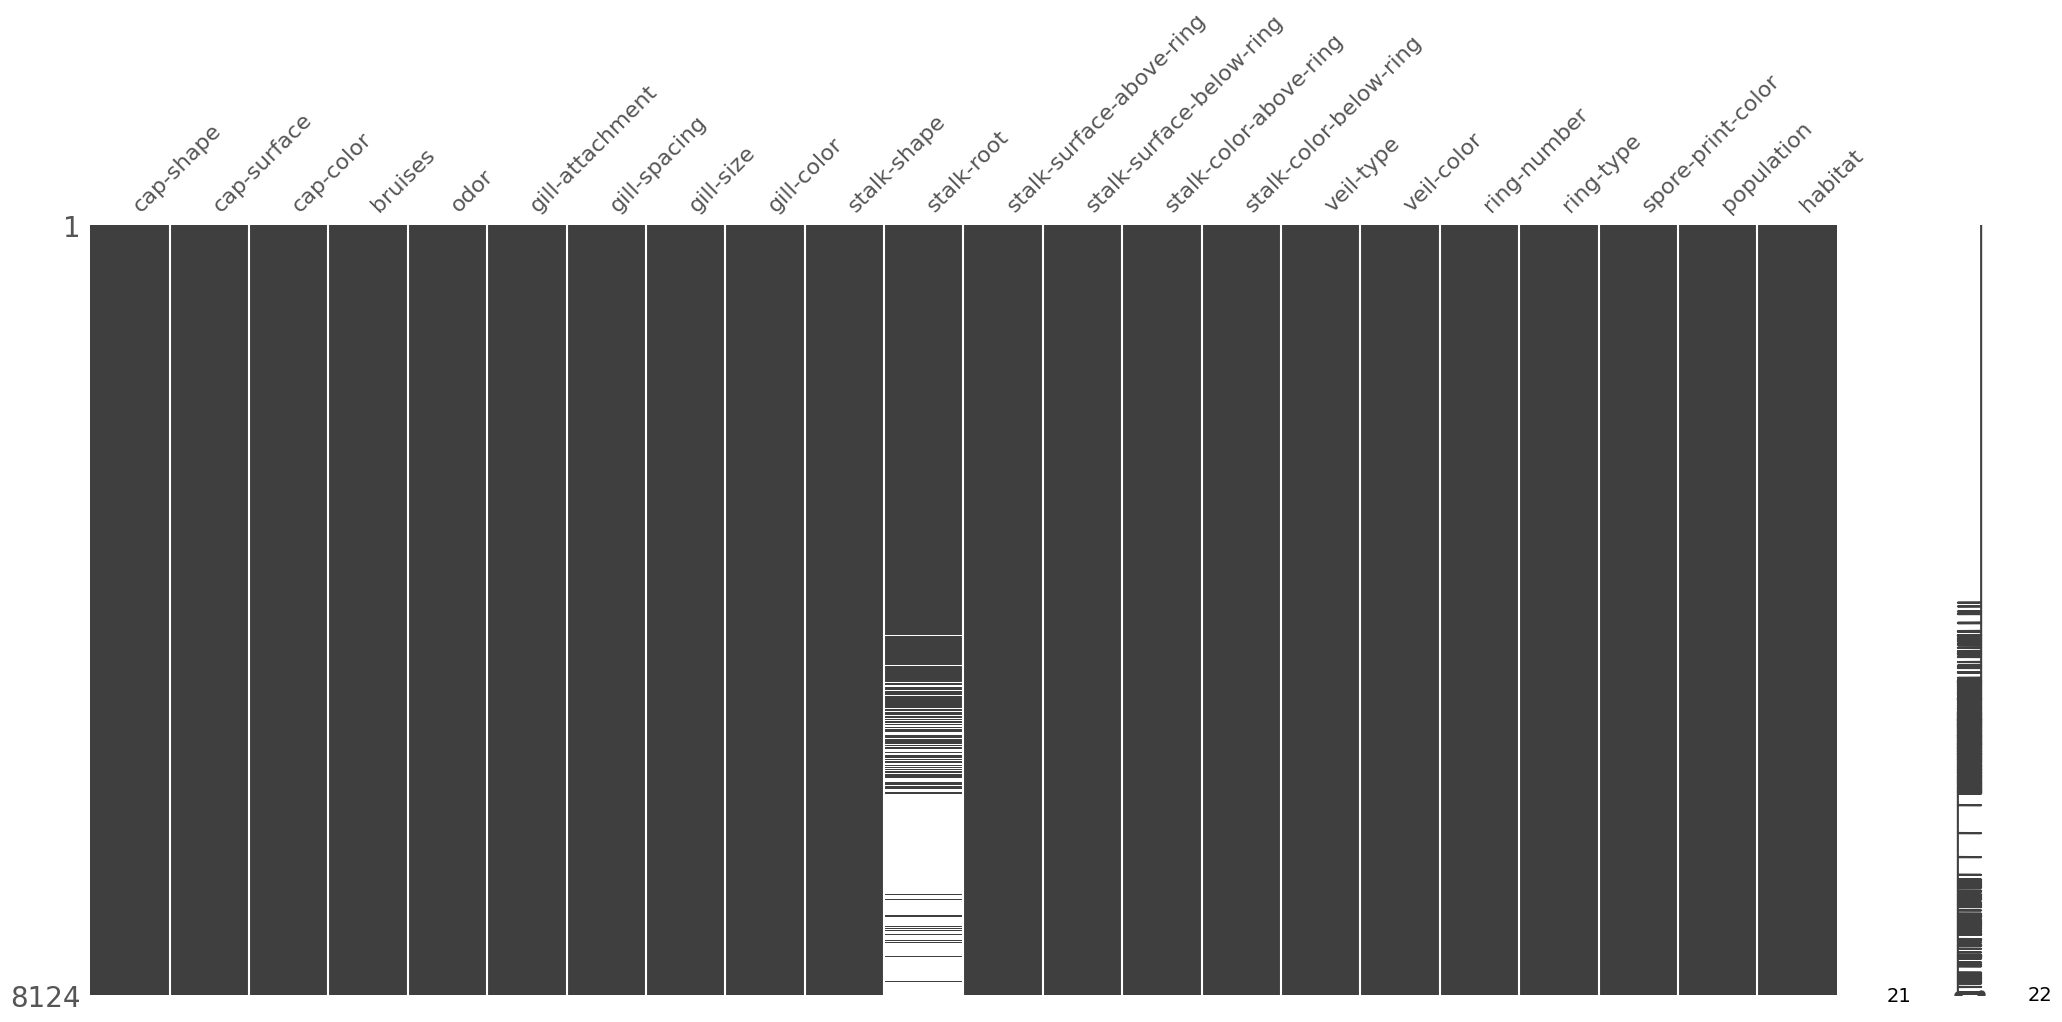

In [19]:
data = mushroom.data.features

msno.matrix(data)
plt.show()

In [20]:
missing_percentage = (data['stalk-root'].isnull().sum() / len(data)) * 100
print(f'stalk-root is missing: {missing_percentage:.2f}%')

stalk-root is missing: 30.53%


The `"stalk-root"` feature is missing data in 30% of rows. I have very little domain knowledge in this area, so it's not obvious how we should handle this situation.  

I'm going to consider these two approaches because the number of rows with missing data is so large:  

- Drop the column and check model performance  
- Investigate if the stalk root is correlated with other features and use regression imputation to predict the value  

Regression imputation will take some work, so I'll use it at the end of the project when validating model performance.  

In [21]:
data_drop_stalk = data.drop('stalk-root', axis = 1)

This data set is made up of categorical features, so it will be necessary to use one-hot encoding.

In [22]:
data = pd.get_dummies(data_drop_stalk, columns=data_drop_stalk.columns)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Columns: 112 entries, cap-shape_b to habitat_w
dtypes: bool(112)
memory usage: 888.7 KB


I will also add the target column to the dataset to get ready for binary classification.

In [26]:
data['poisonous'] = mushroom.data.targets['poisonous'].map({'p': True, 'e': False})
data.describe()

,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,...,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w,poisonous
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
top,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
freq,7672,8120,4972,7296,8092,4468,5804,8120,5568,4880,...,4084,6412,4976,5976,7292,7832,6980,7756,7932,4208


And I will check for imbalance in the data between poisonous or edible mushrooms.

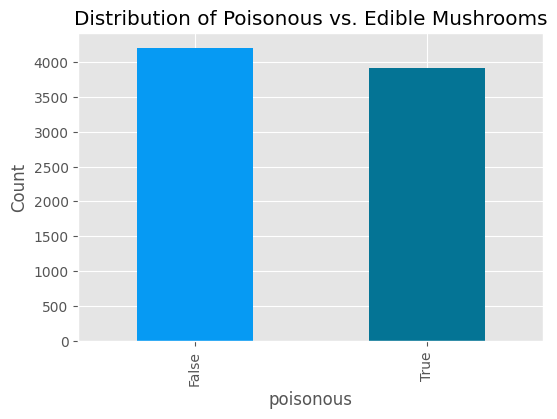

In [33]:
plt.figure(figsize=(6, 4))
plt.title('Distribution of Poisonous vs. Edible Mushrooms')
plt.xlabel('Poisonous (True) / Edible (False)')
plt.ylabel('Count')
plt.xticks(rotation=0)
data['poisonous'].value_counts().plot(kind='bar', color=colors)
plt.show()

The data seems balanced.

## Exploratory Data Analysis  

First, I'll use correlation matrix analysis to identify highly correlated feature pairs.

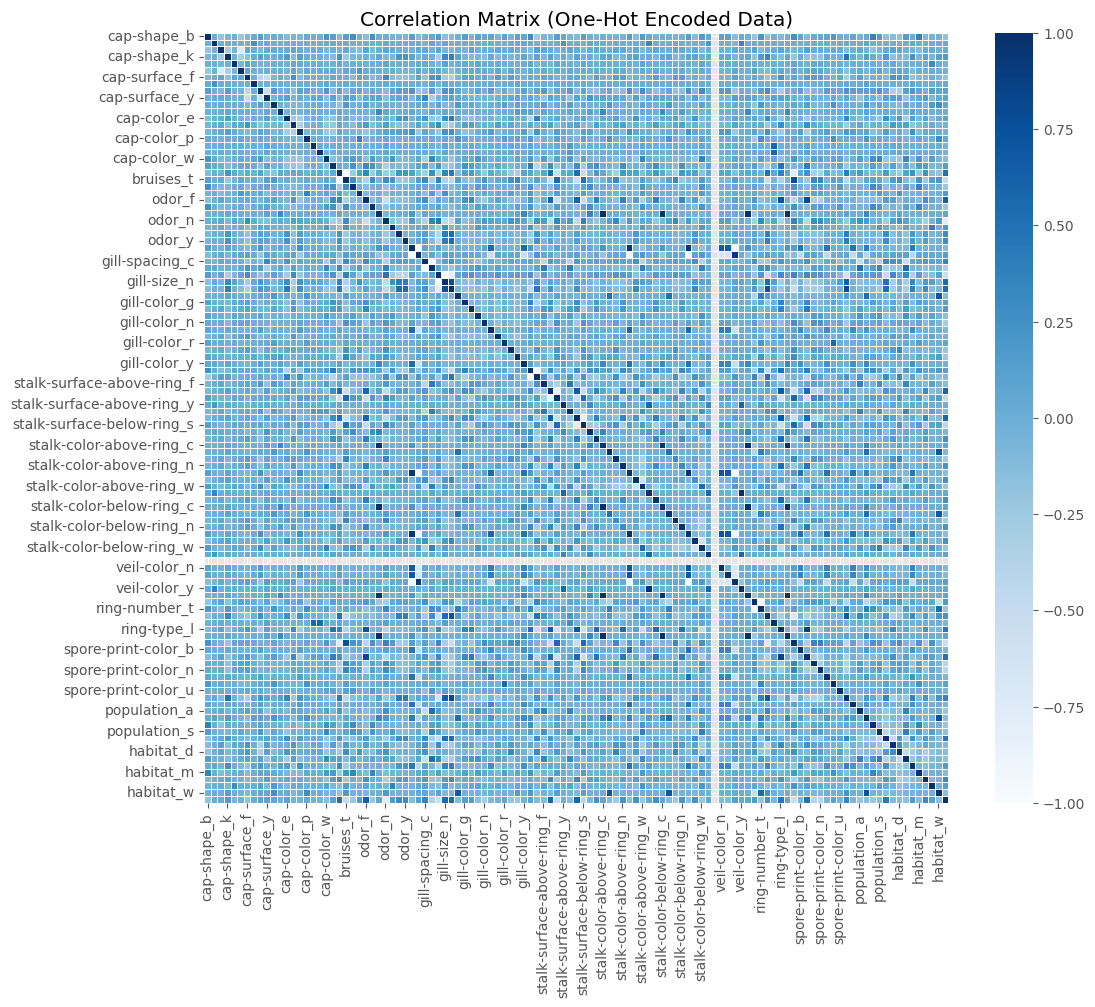

In [35]:
correlation_matrix = data.corr(method='pearson')

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap="Blues", linewidths=.5, fmt=".2f")
plt.title("Correlation Matrix (One-Hot Encoded Data)")
plt.show()

In [36]:
corr_threshold = 0.9
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > corr_threshold:
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

print(f"Number of highly correlated feature pairs (>{corr_threshold}): {len(high_corr_pairs)}")
if len(high_corr_pairs) > 0:
    print("Sample of highly correlated features:")
    for pair in high_corr_pairs[:5]:
        print(f"{pair[0]} and {pair[1]}: {pair[2]:.2f}")

Number of highly correlated feature pairs (>0.9): 26
Sample of highly correlated features:
bruises_f and bruises_t: -1.00
odor_m and stalk-color-above-ring_c: 1.00
odor_m and stalk-color-below-ring_c: 1.00
odor_m and ring-number_n: 1.00
odor_m and ring-type_n: 1.00


These correlated features will be relevant when building a linear regression model that is subject to collinearity issues.

I also want to make sure the data does not have an individual feature that is perfectly linear to the poisonous value.

In [37]:
df = mushroom.data.features
df['poisonous'] = mushroom.data.targets['poisonous'].map({'p': True, 'e': False})

significantly_associated = []

for column in df.columns:
    if column != 'poisonous':
        contingency_table = pd.crosstab(df[column], df['poisonous'])
        _oddsratio, p = fisher_exact(contingency_table)
        if p < 0.005:
            significantly_associated.append((p, column))

print(significantly_associated)

[(np.float64(0.0001), 'cap-shape'), (np.float64(0.0001), 'cap-surface'), (np.float64(0.0001), 'cap-color'), (np.float64(0.0), 'bruises'), (np.float64(0.0001), 'odor'), (np.float64(3.236215053093696e-36), 'gill-attachment'), (np.float64(1.586462564237344e-248), 'gill-spacing'), (np.float64(0.0), 'gill-size'), (np.float64(0.0001), 'gill-color'), (np.float64(3.78188963383688e-20), 'stalk-shape'), (np.float64(0.0001), 'stalk-root'), (np.float64(0.0001), 'stalk-surface-above-ring'), (np.float64(0.0001), 'stalk-surface-below-ring'), (np.float64(0.0001), 'stalk-color-above-ring'), (np.float64(0.0001), 'stalk-color-below-ring'), (np.float64(0.0001), 'veil-color'), (np.float64(0.0001), 'ring-number'), (np.float64(0.0001), 'ring-type'), (np.float64(0.0001), 'spore-print-color'), (np.float64(0.0001), 'population'), (np.float64(0.0001), 'habitat')]


I want to make sure that these significantly associated data points are balanced across the dataset to ensure that one feature is not a clear signal on its own. I'll examine the categorical distribution of these features across edible and poisonous mushrooms to see if any single feature is especially predictive.  

In [38]:
df = mushroom.data.features
df['poisonous'] = mushroom.data.targets['poisonous'].map({'p': True, 'e': False})

df = df[[f[1] for f in significantly_associated] + ['poisonous']]

edible_df = df[df['poisonous'] == False]
poisonous_df = df[df['poisonous'] == True]

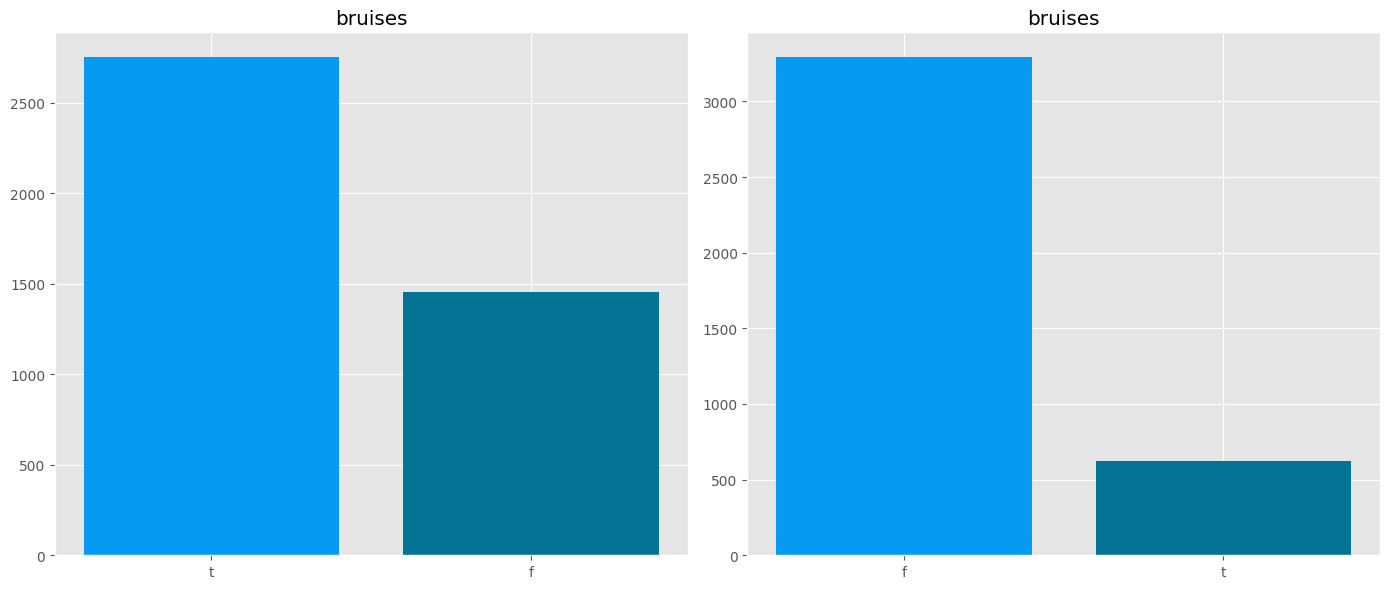

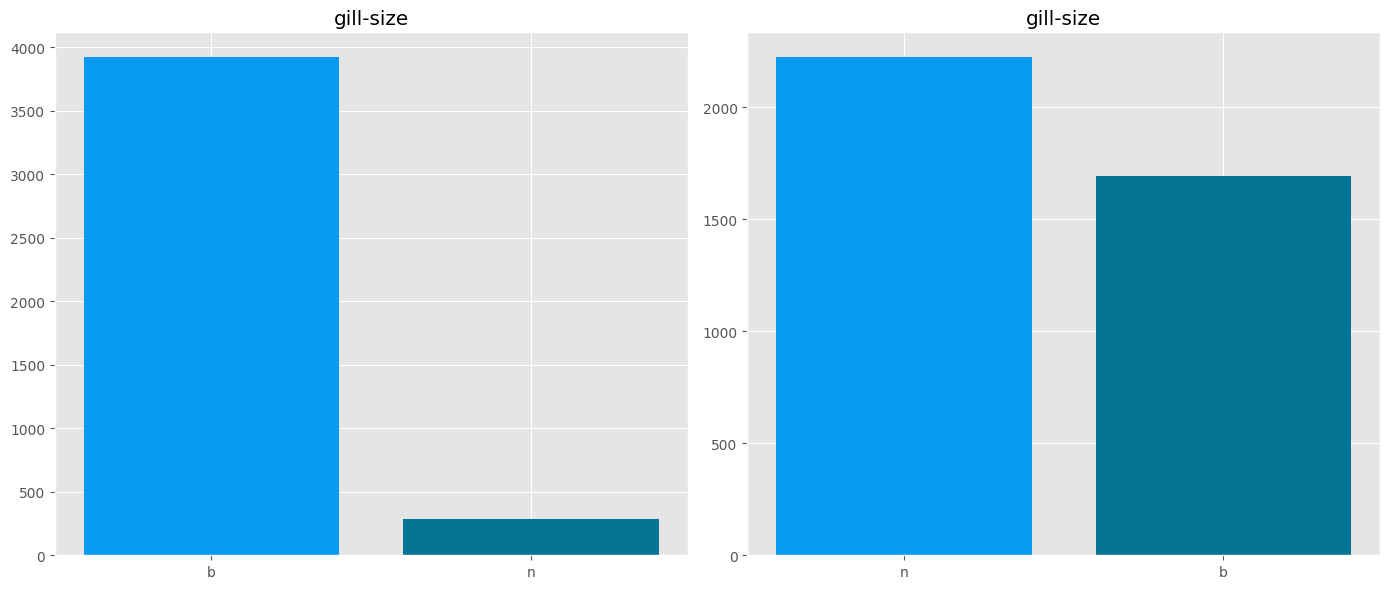

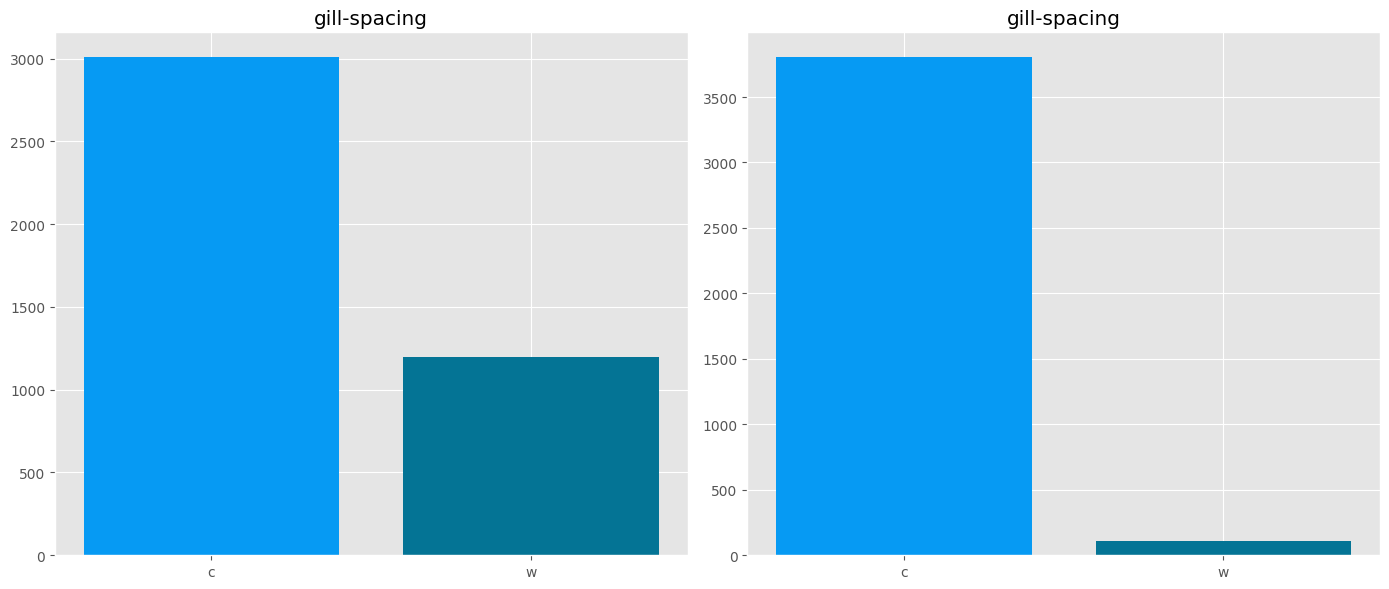

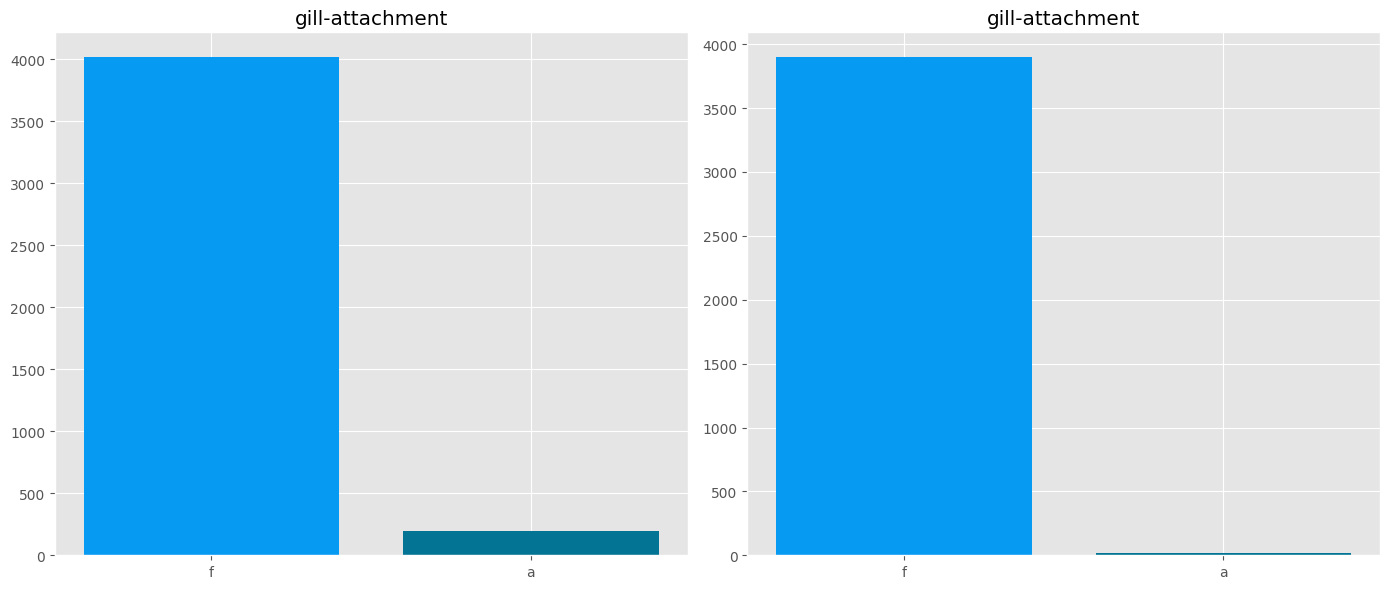

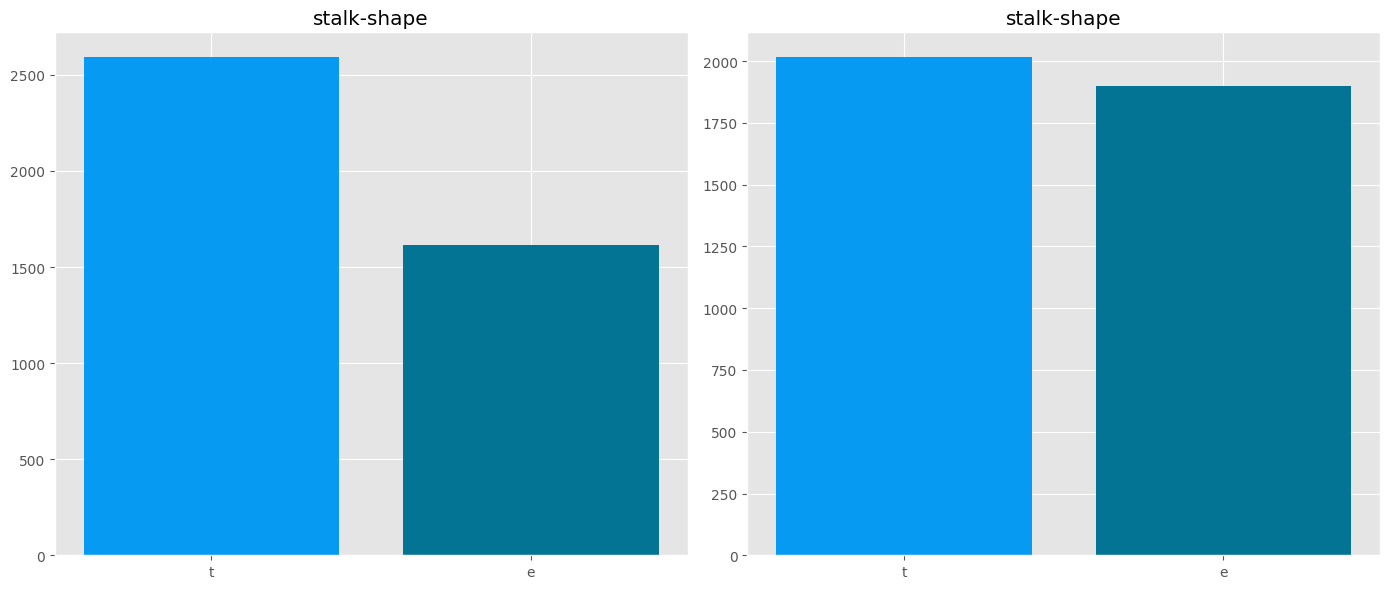

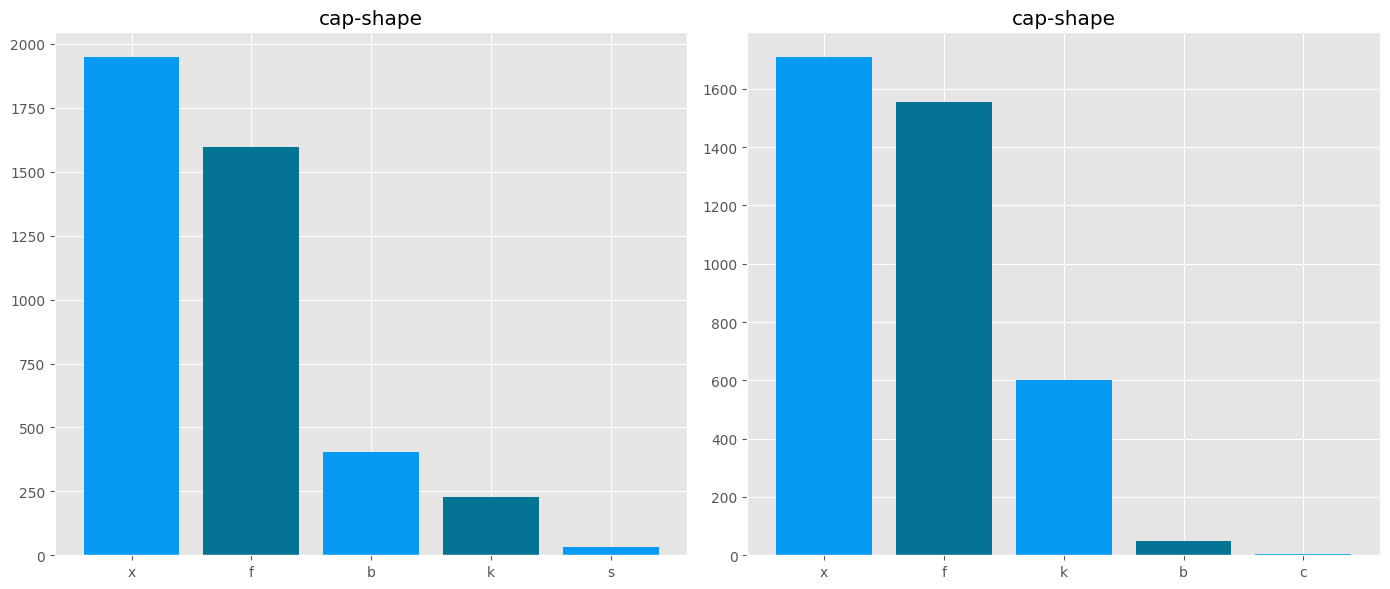

In [40]:
features = sorted(significantly_associated, key=lambda x: x[0])

for i in range(6):
    feature = features[i]
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    axes[0].bar(edible_df[feature[1]].value_counts().index, edible_df[feature[1]].value_counts().values, color=colors)
    axes[0].set_title(feature[1])
    
    axes[1].bar(poisonous_df[feature[1]].value_counts().index, poisonous_df[feature[1]].value_counts().values, color=colors)
    axes[1].set_title(feature[1])
    
    plt.tight_layout()
    plt.show()

As a final step, I will break the data into test and train samples to properly evaluate model performance.

In [41]:
x = data.drop('poisonous', axis=1)
y = data['poisonous']

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=3
)

### Conclusions  

This dataset is well-prepared and required minimal cleaning. I used statistical tests and a correlation matrix to determine which features are significantly correlated. Additionally, I performed frequency analysis to confirm that these features are balanced and evenly distributed across all mushrooms.  

One column contained missing data, requiring a decision on how to handle it. My initial models will be built by removing this column completely due to the large amount of missing data. However, I will explore regression imputation when drawing conclusions at the end of the project.  

Some features exhibit high correlation with one another, which may result in collinearity in my logistic regression model. This issue will be addressed in the modeling section of the project.  

## Models

### Logistic Regression  

Because this dataset contains highly correlated features, I will use **Lasso** regularization to select features and automatically handle collinearity. I will perform a grid search to test different hyperparameter values for **C** and select the best model.  

In [43]:
# Find the best hyperparams by evaluating all options on training data
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(
    LogisticRegression(penalty='l1', solver='liblinear', random_state=3),
    param_grid,
    scoring='accuracy'
)
grid_search.fit(x_train, y_train)

print(f"Best parameter: {grid_search.best_params_}")
model_l1 = grid_search.best_estimator_

# Measure model accuracy on test data
y_pred_l1 = model_l1.predict(x_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_l1):.4f}")
print(classification_report(y_test, y_pred_l1))

# Rank features by importance
#
# Feature importance is measured by 
# taking the absolute value of the 
# coefficient of the feature in the model
feature_importance = pd.DataFrame({
    'Feature': x.columns,
    'Coefficient': model_l1.coef_[0]
})
feature_importance['Abs_Coefficient'] = np.abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

print("\nTop features:")
print(feature_importance.head(15))

Best parameter: {'C': 10}
Accuracy: 1.0000
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1279
        True       1.00      1.00      1.00      1159

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438


Top features:
                        Feature  Coefficient  Abs_Coefficient
95          spore-print-color_r    14.953797        14.953797
23                       odor_c     9.517945         9.517945
24                       odor_f     8.266173         8.266173
28                       odor_p     7.079277         7.079277
86                  ring-type_f    -5.785554         5.785554
25                       odor_l    -5.638605         5.638605
37                 gill-color_b     5.609611         5.609611
22                       odor_a    -5.500724         5.500724
27                       odor_n    -3.865249         3.86

### Decision Tree  

Random forest seems like the ideal model for this classification problem because it naturally handles collinearity and feature interactions. I also performed a grid search to determine the best hyperparameters.  

This model selected different top features compared to the logistic regression model, though there is some overlap.  

In [44]:
# Find the best hyperparams by evaluating all options on training data
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=3, n_jobs=-1),
    param_grid=param_grid,
    n_jobs=-1
)
grid_search.fit(x_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
best_rf_model = grid_search.best_estimator_

# Measure model accuracy on test data
y_pred_best = best_rf_model.predict(x_test)
y_prob_best = best_rf_model.predict_proba(x_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_best):.4f}")
print(classification_report(y_test, y_pred_best))

# Rank features by importance
feature_importance = pd.DataFrame({
    'Feature': x.columns,
    'Importance': best_rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop Features:")
print(feature_importance.head(20))


Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy: 1.0000
ROC-AUC: 1.0000
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1279
        True       1.00      1.00      1.00      1159

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438


Top Features:
                        Feature  Importance
27                       odor_n    0.105859
24                       odor_f    0.101480
35                  gill-size_b    0.096356
91          spore-print-color_h    0.055985
56   stalk-surface-below-ring_k    0.051101
36                  gill-size_n    0.050226
37                 gill-color_b    0.045782
52   stalk-surface-above-ring_k    0.035240
89                  ring-type_p    0.032724
20                    bruises_f    0.028705
33               gill-spacing_c    0

### Support Vector Machines  

For SVM, I use a **nonlinear** kernel to handle feature interactions. I perform a grid search to identify the best hyperparameter values.  

In [45]:
# Find the best hyperparams by evaluating all options on training data
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

grid_search = GridSearchCV(
    estimator=SVC(probability=True, random_state=3),
    param_grid=param_grid,
    n_jobs=-1
)
grid_search.fit(x_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
best_svm_model = grid_search.best_estimator_

# Measure model accuracy on test data
y_pred_best = best_svm_model.predict(x_test)
y_prob_best = best_svm_model.predict_proba(x_test)[:, 1]
print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_best):.4f}")
print(classification_report(y_test, y_pred_best))

Best parameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Accuracy: 1.0000
ROC-AUC: 1.0000
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1279
        True       1.00      1.00      1.00      1159

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438



## Results and Analysis

The primary result I observed is that every approach was very successful at predicting mushroom toxicity based on the features provided. Every final model produced the same confusion matrix, achieving perfect accuracy.  

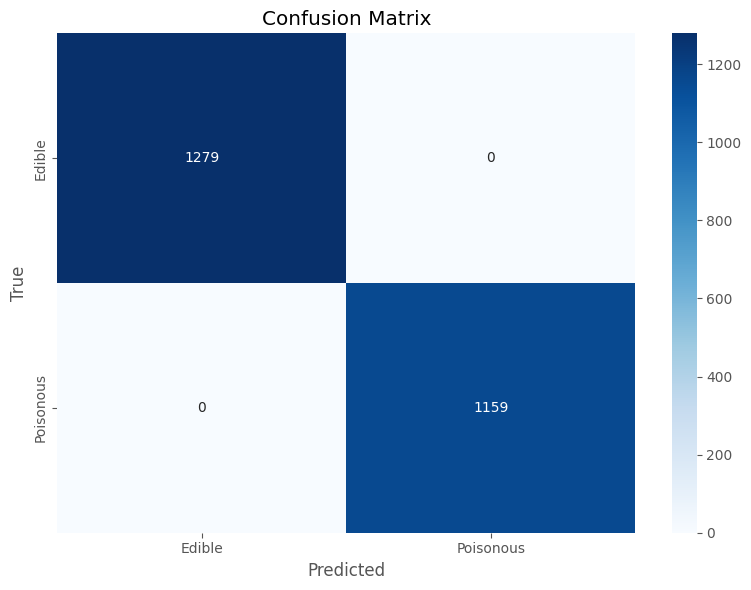

In [46]:
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Edible', 'Poisonous'], 
            yticklabels=['Edible', 'Poisonous'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

The specific results for each model are next to the model itself. Each model uses the performance measurements that are best for their respective method of prediction, however they are all maxed out because of the perfect results on this data set.

Given that each model performed the same, I would recommend using the logistic regression approach because of its speed of computation.

### Imputation

I wanted to explore the `"stalk-root"` feature more and see if it is valuable. I used a random forest classifier to impute the missing stalk root values and then rerun my logistic regression model to see if it is a valuable feature.

In [64]:
mushroom_data = mushroom.data.features.copy()

mushroom_data['stalk-root']

missing_mask = mushroom_data['stalk-root'].isna()

# Create training set with complete records
X_complete = mushroom_data[~missing_mask].drop('stalk-root', axis=1)
y_complete = mushroom_data.loc[~missing_mask, 'stalk-root']

# One-hot encode this new data set
X_encoded = pd.get_dummies(X_complete, drop_first=True)

# Create a test set with stalk-root removed
X_missing = mushroom_data[missing_mask].drop('stalk-root', axis=1)
X_missing_encoded = pd.get_dummies(X_missing, drop_first=True)
missing_cols = set(X_encoded.columns) - set(X_missing_encoded.columns)
for col in missing_cols:
    X_missing_encoded[col] = 0
X_missing_encoded = X_missing_encoded[X_encoded.columns]

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_encoded, y_complete)

# Predict missing values
stalk_root_predictions = model.predict(X_missing_encoded)

# Impute the predicted values
mushroom_data.loc[missing_mask, 'stalk-root'] = stalk_root_predictions

print(f"Unique values in stalk-root after imputation: {mushroom_data['stalk-root'].unique()}")
print(f"Missing values remaining: {mushroom_data['stalk-root'].isna().sum()}")

Unique values in stalk-root after imputation: ['e' 'c' 'b' 'r']
Missing values remaining: 0


In [65]:
# Prep data for use in logistic regression as above in model section
mushroom_data = pd.get_dummies(mushroom_data, columns=mushroom_data.columns)
mushroom_data['poisonous'] = mushroom.data.targets['poisonous'].map({'p': True, 'e': False})
x = mushroom_data.drop('poisonous', axis=1)
y = mushroom_data['poisonous']
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=3
)

# Train model with the ideal hyper params we found earlier
model_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=10, random_state=3)
model_l1.fit(x_train, y_train)

# Report accuracy and find how important stalk-root was as a feature
y_pred_l1 = model_l1.predict(x_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_l1):.4f}")
print(classification_report(y_test, y_pred_l1))

feature_importance = pd.DataFrame({
    'Feature': x.columns,
    'Coefficient': model_l1.coef_[0]
})
feature_importance['Abs_Coefficient'] = np.abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

stalk_root_indices = feature_importance[feature_importance['Feature'].str.startswith('stalk-root')].index
print(f"Indices of features starting with 'stalk-root': {stalk_root_indices} out of {len(feature_importance)-1}")

Accuracy: 1.0000
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1279
        True       1.00      1.00      1.00      1159

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438

Indices of features starting with 'stalk-root': Index([51, 54, 53, 52], dtype='int64') out of 117


Based on this test, it appears that **stalk-root** is not a very predictive feature, and it was correct to remove the column during data cleaning. There may be better ways to approach this test that I would love to explore in the future, but this was the experiment I thought made sense for the project.

## Conclusion



Each supervised learning approach I used was able to perform very well on this data, and I believe I achieved my goal of building a model that can predict whether a mushroom is edible given the constraints of this dataset.

Since every model performed well, I would recommend using a **Logistic Regression** model with **Lasso regularization** and a `C` value of `10` for making predictions in applications.

I learned that each model was able to perform well while identifying a unique set of features, which suggests that we would likely see significant deviations in accuracy with a sufficiently large dataset. I would love to collect a larger dataset or explore noise generation techniques to dive deeper into the limitations of each approach, but that can be a follow-up project.

I was surprised to see that `stalk-root` was not an important feature and could be safely removed without dramatically changing model performance. This made me wonder what other features we could remove and whether my test for determining the importance of that feature was valid. Exploring different imputation methods could be a project of its own.

To improve my models, I would look into ways to remove features while maintaining performance, thus making the model simpler and faster. I would also like to investigate scaling techniques and pre-select the best feature set before training the **SVM** model to achieve better training times. Additionally, I would like to analyze the **Decision Tree** model that was found to be the most optimal and explore methods for reducing its depth, so it could train faster as well.